In [2]:
import xarray as xr
import numpy as np
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
import imageio.v2 as imageio
import numpy as np
import sparse 
import os

##read the cdo merged h1 output files from the 70 year simulation or 1 year simulation(monthly) concatenated using cdo

In [3]:
filename = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_BECCS_land_190124/lnd/hist/All_NSSP534frc2esm_f19_tn14_BECCS_land_190124.clm2.h1_2030_2035.nc' ###sugarcane with CCS
data = xr.open_dataset(filename, decode_times=False)
data

IOStream.flush timed out


<xarray.Dataset>
Dimensions:             (time: 71, bnds: 2, lon: 144, lat: 96, gridcell: 5701,
                         landunit: 17795, column: 142368, pft: 222182)
Coordinates:
  * time                (time) float64 396.0 424.0 455.0 ... 2.494e+03 2.524e+03
  * lon                 (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Dimensions without coordinates: bnds, gridcell, landunit, column, pft
Data variables: (12/88)
    time_bnds           (time, bnds) float64 ...
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    ...                  ...
    TOTECOSYSN          (time, column) float64 ...
    TOTSOMC             (time, column) float64 ...
    TOTSOMN             (time, column) float64 ...
    TOTVEGC             (time, pft) float64 ...
    TOTVEGN             (time, pft) float64 ...
    WOODC               (time, pft) float64 ...
Attributes: (12/104)
    CDI:                                       Climate Data Interface version...
    source:                                    Community Land Model CLM4.0
    Conventions:                               CF-1.0
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    history:                                   Mon Mar 04 10:31:20 2024: cdo ...
    ...                                        ...
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./NSSP534frc2esm_f19_tn14_BECC...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    CDO:                                       Climate Data Operators version...

IOStream.flush timed out


: 

In [3]:
filename = '/cluster/projects/nn9576k/anusha/DATA/gridarea_192_288.nc'      #default
gridarea = xr.open_dataset(filename, decode_times=False)

##convert the h1 sparse data to normal gridded nc data

In [4]:
for var_name in data.variables:
        if data[var_name].dtype == 'int32':
            data[var_name] = data[var_name].astype('float64')
pft_constants = xr.open_dataset("/cluster/shared/noresm/inputdata/lnd/clm2/paramdata/clm5_params.c171117.nc")
pftnames = pft_constants.pftname
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

In [5]:
sparse_data = convert_pft_variables_to_sparse(data, pftnames)

In [6]:
sparse_data.AGNPP

Format,coo
Data Type,float64
Shape,"(71, 79, 96, 144)"
nnz,14166985
Density,0.18270829670651664
Read-only,True
Size,540.4M
Storage ratio,0.9


In [7]:
sparse_data.pfts1d_wtgcell

Format,coo
Data Type,float64
Shape,"(79, 96, 144)"
nnz,199535
Density,0.18270829670651664
Read-only,True
Size,6.1M
Storage ratio,0.7


##first write the output NPP in gc/m2/sec to gridded nc data 

In [17]:
##AGAGNPP for sugarcane in gC/m²/sec
selected_vegtypes = [67,68]
AGNPP_cane =(sparse_data.AGNPP.isel(vegtype=selected_vegtypes)*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes)).sum('vegtype') 
AGNPP_cane_nc = AGNPP_cane.as_numpy()
AGNPP_cane_nc = xr.where(AGNPP_cane_nc >= 0, AGNPP_cane_nc, 0)
AGNPP_cane_nc
AGNPP_cane_nc.name= "AGNPP"
AGNPP_cane_nc.attrs['units'] = "gC/m^2/s"
AGNPP_cane_nc.attrs['cell_methods'] = "time: mean"
AGNPP_cane_nc.attrs['_FillValue'] = 1.e+36
AGNPP_cane_nc.attrs['missing_value'] = 1.e+36
AGNPP_cane_nc.attrs['long_name'] = "net primary production"
AGNPP_cane_nc.to_netcdf('/cluster/projects/nn9576k/anusha/DATA/AGNPP_NSSP534frc2esm_f19_tn14_BECCS_land_190124.clm2.h1.2030_2100_gridded.nc', mode='w', format='NETCDF4')

In [26]:
start_date = '2080-01'
end_date   = '2080-12'
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
NPP_cane_nc=sparse_data.NPP.assign_coords(time=monthly_dates)
NPP_cane_nc= xr.where(NPP_cane_nc < 0, 0, NPP_cane_nc)
NPP_cane_annual = NPP_cane_nc.resample(time='A').sum(dim='time')
NPP_cane_annual

selected_vegtypes = [67,68]
NPP_cane=np.multiply(NPP_cane_annual.isel(vegtype=selected_vegtypes),sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes)).sum('vegtype') 
NPP_cane


Format,coo
Data Type,float64
Shape,"(71, 96, 144)"
nnz,184447
Density,0.18792282048774125
Read-only,True
Size,5.6M
Storage ratio,0.8


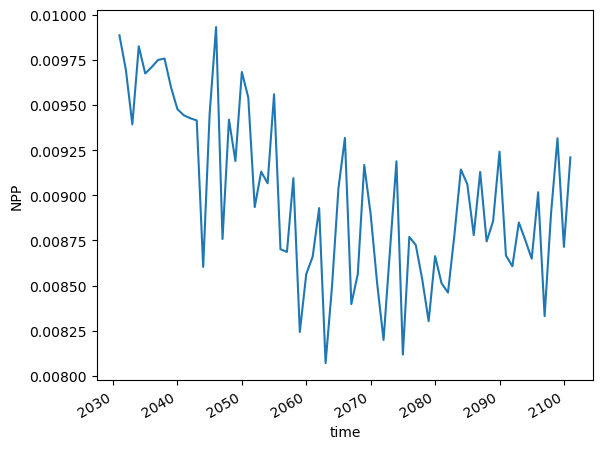

In [27]:
NPP_cane.sum(['lat','lon']).plot()

##Calculate Sugarcane NPP in gC/m2/sec (consider only positive values-not really) and convert to GtC/year

In [6]:
var=NPP_cane_nc.sel(time='2080').sum('time')
annual_yield=var.sum()
fig, axs = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
var.plot()
axs.coastlines(linewidth=1)
axs.set_title('NPP_sugarcane_2080(gC/m2/sec)', fontsize=16, loc='center')
axs.text(0.8, -0.3, f"{annual_yield:.3f}", fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [7]:

NPP_cane_annual = NPP_cane_nc.resample(time='A').sum(dim='time')
NPP_cane_peryear =NPP_cane_annual * (86400 * 30.5) # gC/m2/sec to gC/m2/year
NPP_cane_GtC_year=NPP_cane_peryear*(1e-15)*data.area*(1e6) #gC/m²/year to GtC/year

NPP_cane_GtC_year

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Float64Index'

In [21]:
file_weights = '/cluster/projects/nn9576k/anusha/DATA/weights_sugarcane_NPP_2030-2100_mod.nc'
dset_W = xr.open_dataset(file_weights, decode_times=False)
start_date = '2030'
end_date   = '2101'
years = pd.date_range(start=start_date, end=end_date, freq='A')
dset_W = dset_W.assign_coords(time=years)
dset_W.weights
#weights=dset_W.weights.sel(time=desired_year)
NPP_cane=np.multiply(NPP_cane_GtC_year,dset_W.weights)


NPP_cane.name= "NPP"
NPP_cane.attrs['units'] = "GtC/year"
NPP_cane.attrs['cell_methods'] = "time: mean"
NPP_cane.attrs['_FillValue'] = 1.e+36
NPP_cane.attrs['missing_value'] = 1.e+36
NPP_cane.attrs['long_name'] = "net primary production"
#NPP_cane.to_netcdf('NSSP534frc2esm_f19_tn14_bioenergy_sugarcane_OceanNET_2030_2100_h1_GtC_year.nc', mode='w', format='NETCDF4')

<xarray.DataArray (time: 71, lat: 96, lon: 144)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * time     (time) datetime64[ns] 2030-12-31 2031-12-31 ... 2100-12-31

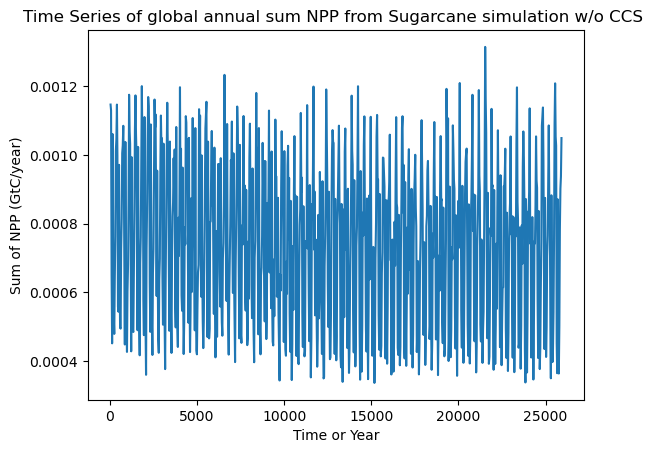

In [12]:
NPP_cane_GtC_sum = NPP_cane.sum(['lat', 'lon'])
NPP_cane_GtC_sum.plot()
plt.xlabel('Time or Year')
plt.ylabel('Sum of NPP (GtC/year)')
plt.title('Time Series of global annual sum NPP from Sugarcane simulation w/o CCS ')
#plt.grid(True)
plt.show()

In [16]:
variables = ['BC_NI_SRF', 'SFBC_A', 'WPTHLP_CLUBB', 'TS', 'T', 'FSNT','FLNT','TREFHT']
results2 = np.zeros((len(variables), (size_iteration)))
results3 = np.zeros((size_iteration))
print(variables[1])
#b=float(np.sum(np.multiply(dset2[variables[1]],np.array(area_grid_cell))/np.sum(area_grid_cell)))
#dset2['TS'] 

SFBC_A


In [26]:
# store in "results"
for i in range(size_iteration):
    #print(i)
    dset2 = xr.open_dataset(list_files2[i], decode_times=False)
    #print(dset2)
    for j in range(len(variables)):
        results2[j, i] = float(np.sum((np.multiply(dset2[variables[j]],np.array(area_grid_cell)))/np.sum(area_grid_cell))) 
    #results3[i] = float(np.sum((np.multiply(dset2[variables[5]-variables[6]],np.array(area_grid_cell)))/np.sum(area_grid_cell)))  
    print(np.sum((np.multiply((dset2[variables[5]]-dset2[variables[6]]),np.array(area_grid_cell))/np.sum(area_grid_cell))))
    results3[i] = np.sum((np.multiply((dset2[variables[5]]-dset2[variables[6]]),np.array(area_grid_cell))/np.sum(area_grid_cell)))
   

<xarray.DataArray ()>
array(6.93607473)
<xarray.DataArray ()>
array(-9.90435123)
<xarray.DataArray ()>
array(-21.6349472)
<xarray.DataArray ()>
array(-26.82785174)
<xarray.DataArray ()>
array(-31.80727757)
<xarray.DataArray ()>
array(-35.68232718)
<xarray.DataArray ()>
array(-36.24715742)
<xarray.DataArray ()>
array(-33.87360043)
<xarray.DataArray ()>
array(-29.11062157)
<xarray.DataArray ()>
array(-24.90794334)
<xarray.DataArray ()>
array(-22.18722189)


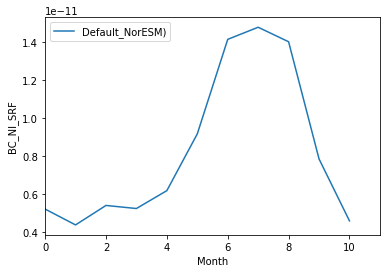

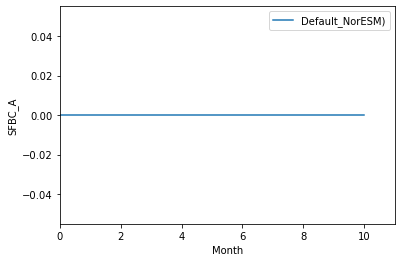

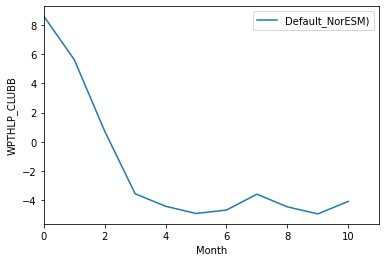

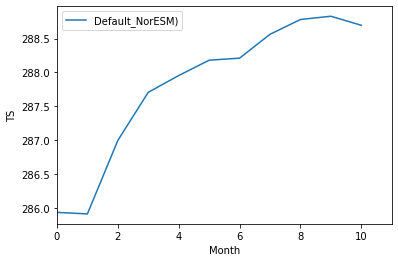

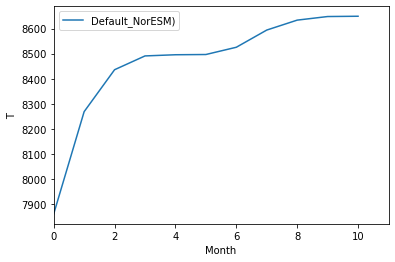

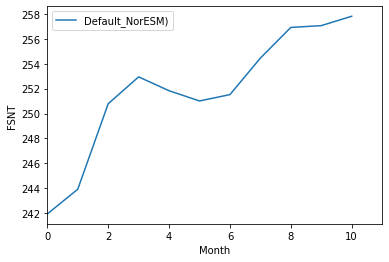

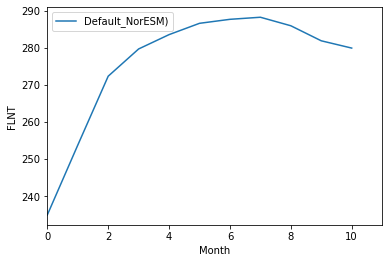

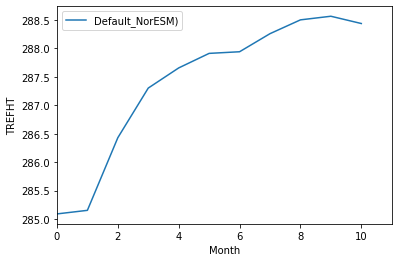

In [6]:
# plot
for k in range(len(variables)):
    fig, ax = plt.subplots()
    #plt.plot(results[k], label='No shipping (control)')
    plt.plot(results2[k], label='Default_NorESM')
    #print(results2[k] / results[k])
    plt.xlim(0,size_iteration)
    plt.xlabel('Month')
    plt.ylabel(variables[k])
    plt.legend()
    #plt.savefig(variables[k]+'.png')

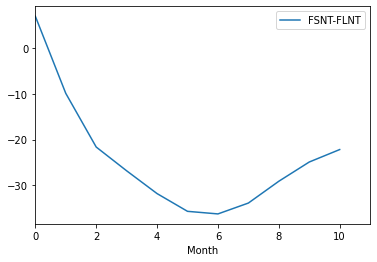

In [29]:

fig, ax = plt.subplots()
#plt.plot(results[k], label='No shipping (control)')
plt.plot(results3, label='FSNT-FLNT')
#print(results2[k] / results[k])
plt.xlim(0,size_iteration)
plt.xlabel('Month')
#plt.ylabel(variables[k])
plt.legend()
plt.show() 


In [41]:
list_files2 = glob.glob("/cluster/work/users/a2021/noresm/NF2018fsst_f09_f09_mg17_2023_final/run/NF2018fsst_f09_f09_mg17_2023_final.cice.h.2018*nc")
list_files2 = sorted(list_files2)
size_iteration = len(list_files2)
list_files2000 = glob.glob("/cluster/work/users/a2021/archive/NF2000fsstdef/ice/hist/NF2000fsstdef.cice.h.0011*")
list_files2000 = sorted(list_files2000)
size_iteration2000 = len(list_files2000)
variables = ['snowfrac', 'fswup', 'dsnow']
#variables = ['landfrac', 'BCDEP', 'EFLX_LH_TOT', 'FLDS']
results2 = np.zeros((len(variables), (size_iteration)))
results2000 = np.zeros((len(variables), (size_iteration)))
for i in range(size_iteration):
    dset2 = xr.open_dataset(list_files2[i], decode_times=False)
    print(dset2['snowfrac'])
    dset2000 = xr.open_dataset(list_files2000[i], decode_times=False)
    for j in range(len(variables)):
        results2[j, i] = float(np.sum((np.multiply(dset2[variables[j]],np.array(area_grid_cell)))/np.sum(area_grid_cell))) 
        results2000[j, i] = float(np.sum((np.multiply(dset2000[variables[j]],np.array(area_grid_cell)))/np.sum(area_grid_cell)))  
        print(results2)



<xarray.DataArray 'snowfrac' (time: 1, nj: 192, ni: 288)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.841222, 0.84392 , ..., 0.840552, 0.841217],
        [0.824505, 0.824505, ..., 0.824505, 0.824505]]], dtype=float32)
Coordinates:
  * time     (time) float32 7.366e+05
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      grid cell mean snow fraction
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
[[0.02779308 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.

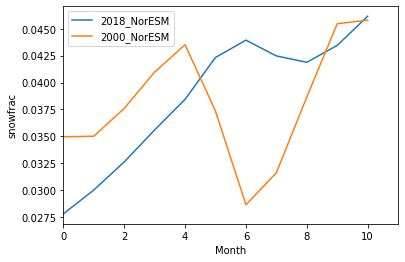

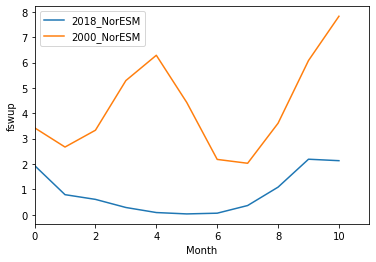

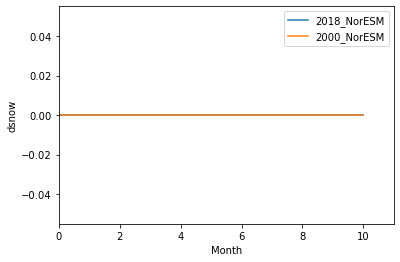

In [37]:
for k in range(len(variables)):
    fig, ax = plt.subplots()
    plt.plot(results2[k], label='2018_NorESM')
    plt.plot(results2000[k], label='2000_NorESM')
    plt.xlim(0,size_iteration)
    plt.xlabel('Month')
    plt.ylabel(variables[k])
    plt.legend()
